
## Open Source Tools For Rapid Statistical Model Development

### Overview
* Catching up with Probabilistic Programming
* Plan models -- causalgraphicalmodels
* Loading Data -- PANDAS
* Preparing Data -- PANDAS, Seaborn, Scikit-learn
* Rapid Model Development -- PyMC3
* Beyond the Basics

<a id='TOP'></a>
### Notebook Content:
1. [PP Overview](#Overview)
    1. PP as modeling framework
    2. Emphasis on generalizing predictive models
1. [Plan modeling](#ModelPlan)
2. [Loading Field Data](#DataLoad)
3. [Prepare Data for Modeling](#DataPrep)
4. [Bayesian Modelling](#PyMC3)
   1. [Model coding](#writemodel)
   2. [Prior evaluation & Model modification](#priors)
   3. [Model fitting & diagnostics](#fit)
   4. [Model Evaluation](#eval)
       1. [Deviance](#deviance)
       2. [Approximation by WAIC](#waic)
5. [Conclusion](Conclusion)

In [106]:
# STL
import sys
import pickle

# numerical libraries
import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# graphic facilities
from matplotlib import rcParams
import matplotlib.pyplot as pl
import seaborn as sb

In [3]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [4]:
print(f'Python: version {sys.version.split("|")[0]}')
print(f'PanDaS version {pd.__version__}')
print(f'Seaborn version {sb.__version__}')
print(f'PyMC3 version {pm.__version__}')

Python: version 3.7.1 
PanDaS version 0.24.1
Seaborn version 0.9.0
PyMC3 version 3.6


In [25]:
%matplotlib inline

### Loading and preparing data -- PANDAS
* the nomad dataset
* reading in 
* get column names
* extract desired variables

### Data Exploration -- PANDAS, Seaborn and Scikit-Learn
* predictor isolated distributions
* plotting predictors/predicted w/ respect to each other
* predictor correlation, multicollinearity and pca

### Modeling -- Probabilistic Programming with PyMC3
* simple bayesian regression to predict chlorophyll from Rrs
* rapid but transparent model development
* evaluation of priors
* fitting and evaluation of posterior distribution
* model comparison/selection

<a id=DataLoad></a>
## 2. "<u>Loading Field Data</u>
<br>
<span style="font-size:16pt">$\ \ \ \Rightarrow$ NOMAD SeaWiFS validation match-up distribution</span><br>
<img src='./resources/nomad_seabass_v1_seawifs_map.png' width=600 title="NOMAD SeaWiFS validation match-up distribution"/>

<span style="font-size:16pt">$\Rightarrow$   <u>Predictors</u></span>
* sat_rrs  ~ satellite remote-sensing reflectance (sr-1)
* etopo2 ~ NGDC ETOPO2 water depth (meters)
* oisst    ~ optimal interpolation (OI) sea surface temperature (SST) (degrees C)
* senz     ~ satellite viewing (zenith) angle (degrees)
* solz     ~ solar zenith angle at time of satellite overpass (degrees)
---
<span style="font-size:16pt">$\Rightarrow$   <u>Predicted</u></span>
* chl ~ fluorometric chlorophyll a

<u>Other</u>
* id ~ NOMAD record identifier (unitless)

<span style="font-size:16pt">$\Rightarrow$   <u>File content</u></span>
<br><br>
/fields=year,month,day,hour,minute,second,lat,lon,id,oisst,etopo2,chl,chl_a,kd405,kd411,kd443,kd<br>
...<br>
_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid<br>
/units=-999<br>
/end_header<br>
1997,10,07,09,41,00,42.51,39.52,4065,19.54,1982,0.401,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,

In [7]:
with open('./nomad_seawifs_v1.3_2005262.txt') as f:
    for i, line in enumerate(f.readlines()):
        if 'fields' in line:
            # collect column labels
            col_names = line.strip('/fields=').strip().split(',') 
        if '/end_header' in line:
            # record columns to skip
            rowskips = i+1
            break

In [8]:
df = pd.read_csv('./nomad_seawifs_v1.3_2005262.txt', header=None,
                 names=col_names, skiprows=rowskips, na_values=-999)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Columns: 169 entries, year to valid
dtypes: float64(157), int64(10), object(2)
memory usage: 385.6+ KB


In [14]:
df.head()

,year,month,day,hour,minute,second,lat,lon,id,oisst,...,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid
0,1997,10,7,9,41,0,42.5100,39.5200,4065,19.54,...,0.00345,0.00297,0.00217,0.00026,S1997280094210.L1A_GAC,480,49.0,25.4,0.2098,0
1,1997,10,11,9,32,0,39.2900,25.1100,4069,19.57,...,0.00494,0.00348,0.00191,0.00018,S1997284110315.L1A_MLAC,5880,48.7,37.8,0.1043,1
2,1997,9,27,11,29,0,24.1392,-20.9995,6083,24.67,...,0.00625,0.00375,0.00168,0.00022,S1997270134450.L1A_MLAC,8880,28.0,35.5,0.1012,1
3,1998,5,16,8,30,0,-32.3397,17.8766,6119,17.21,...,0.00177,0.00193,0.00196,0.00055,S1998136102611.L1A_MLAC,7200,51.6,22.4,0.0940,1
4,1998,5,16,9,16,0,-32.3447,17.8735,6120,17.21,...,0.00180,0.00198,0.00199,0.00056,S1998136102611.L1A_MLAC,4440,51.6,22.4,0.0836,1


In [ ]:
def Daylight(row):
    l = astral.Location()
    l.latitude = row['lat']
    l.longitude = row['lon']
    try:
        td = l.sunset(date=row['datetime']) - l.sunrise(date=row['datetime'])
        return td.seconds
    except:
        return np.NaN

<a id=DataPrep></a>
## 3. <u>Data Preparation</u>
<br>

In [15]:
date_time_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
df.insert(0, 'datetime', pd.to_datetime(df[date_time_columns],
                                        format='%Y-%m-%d %H:%M:%S'))

In [17]:
df.drop(date_time_columns, axis=1, inplace=True)

In [22]:
# two types of chlorophyll a:
df.filter(regex='chl', axis=1).info()
# chl: obtained by fluorometry
# chl_a: obtained by hplc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
chl      262 non-null float64
chl_a    33 non-null float64
dtypes: float64(2)
memory usage: 4.6 KB


In [29]:
# Preprocess satellite data
df_sat = df.filter(regex='sat_rrs', axis=1).copy()
# Invalidate negative readings
df_sat[df_sat<=0] = np.NaN
# Log-transform rrs
df_log_sat = pd.DataFrame(np.log10(df_sat.values),
                          columns=[f'log_{col}' for col in df_sat.columns]
                         )

In [145]:
# Preprocess 
df_extr = df[['oisst']].merge(df_log_sat,
                                  right_index=True,
                                  left_index=True)
df.loc[df.etopo2==0, 'etopo2'] = np.NaN
#df_extr.insert(1, 'log_depth', np.log10(df.etopo2))
df_extr['coastal'] = df.etopo2<=30
df_extr['coastal'] = df_extr.coastal.astype('category').cat.codes.astype('int')
df_extr['log_chlor_a'] = np.log10(df.chlor_a.values)

In [146]:
df_extr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 9 columns):
oisst             292 non-null float64
log_sat_rrs412    276 non-null float64
log_sat_rrs443    285 non-null float64
log_sat_rrs490    291 non-null float64
log_sat_rrs510    292 non-null float64
log_sat_rrs555    292 non-null float64
log_sat_rrs670    281 non-null float64
coastal           292 non-null int64
log_chlor_a       292 non-null float64
dtypes: float64(8), int64(1)
memory usage: 20.6 KB


### Splitting data into training & testing sets

In [149]:
X, y = df_extr.loc[:, :'coastal'], df_extr.log_chlor_a

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=X.coastal)

In [151]:
X.coastal.value_counts(normalize=True)

0    0.678082
1    0.321918
Name: coastal, dtype: float64

In [152]:
X_train.coastal.value_counts(normalize=True)

0    0.675799
1    0.324201
Name: coastal, dtype: float64

In [153]:
X_test.coastal.value_counts(normalize=True)

0    0.684932
1    0.315068
Name: coastal, dtype: float64

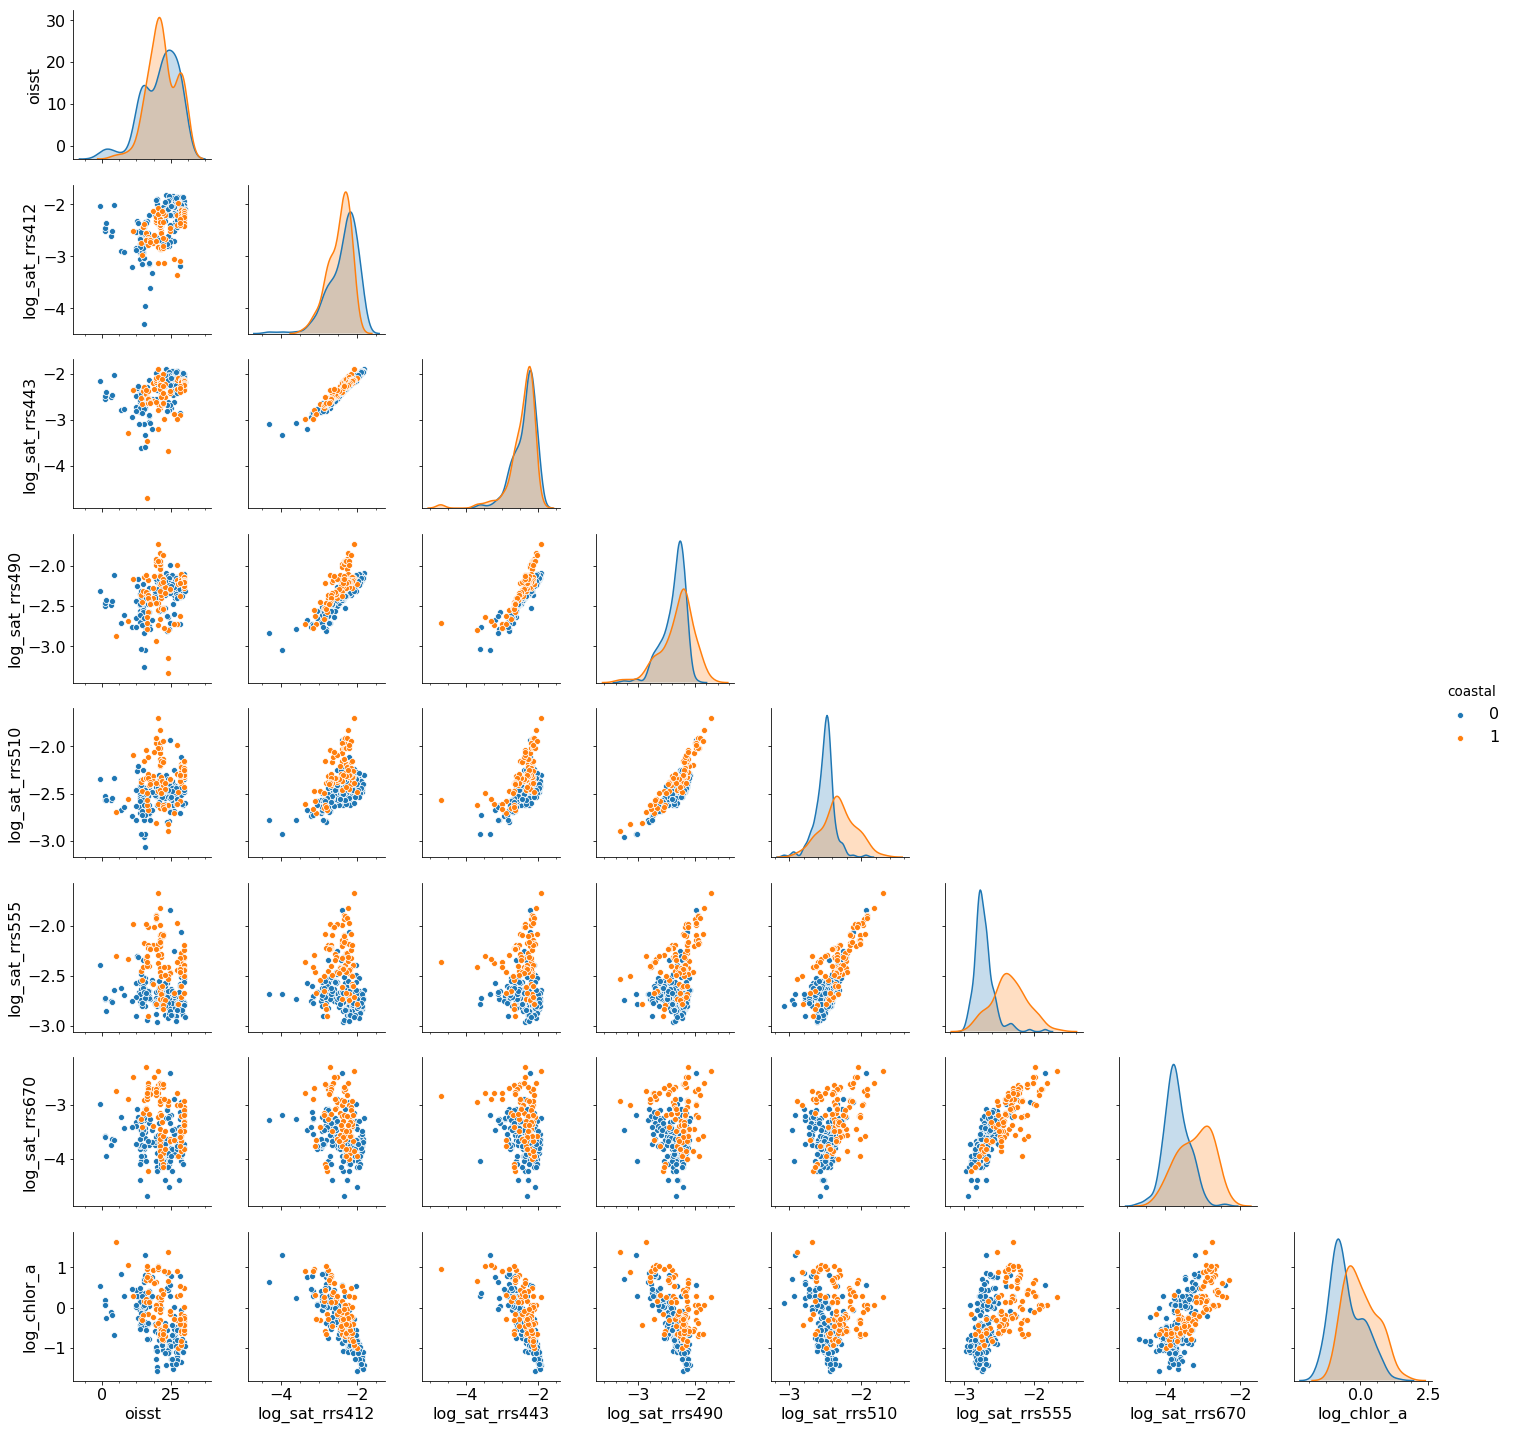

In [155]:
g = sb.pairplot(df_extr, hue='coastal', vars = ['oisst', 'log_sat_rrs412', 
                    'log_sat_rrs443', 'log_sat_rrs490', 'log_sat_rrs510',
                    'log_sat_rrs555', 'log_sat_rrs670', 'log_chlor_a']
       )
# mask upper triangle for readability
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
f = pl.gcf()
f.savefig('./resources/pairgrid.png', dpi=300)

In [186]:
def make_heatmap(input_, filter_=None, figsize=(6, 5)):
    f, ax = pl.subplots(figsize=figsize)
    ax.set_facecolor('k')
    if filter_:
        input_ = input_.filter(regex=filter_, axis=1)
    corr_mat = input_.dropna().corr()
    sb.heatmap(corr_mat, ax=ax, vmin=-1, vmax=1, 
               mask=np.triu(np.ones(corr_mat.shape),), cmap='RdBu', fmt='.2f',
               annot=True)
    return f

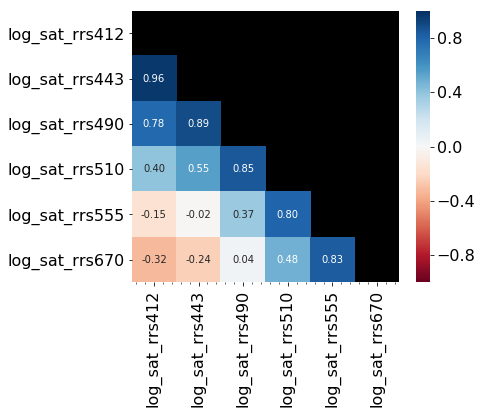

In [187]:
f = make_heatmap(X, filter_='rrs')
f.savefig('./resources/heatmap.png', dpi=300);

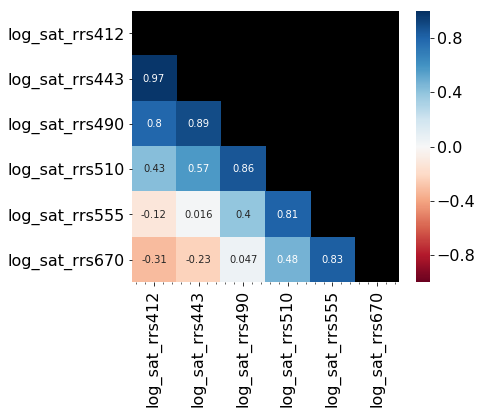

In [166]:
f = make_heatmap(X_train, filter_='rrs')
f.savefig('./resources/heatmap_train.png')

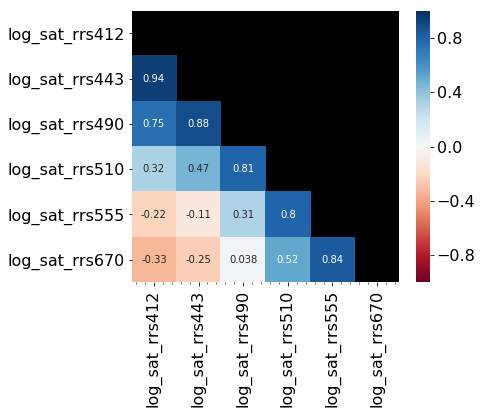

In [168]:
f = make_heatmap(X_test, filter_='rrs')
f.savefig('./resources/heatmap_test.png')

### Computing Principle Components

* parameterize PCA transformer using training set
* compute principle components for training set
* compute principle components for testing set with the same PCA transformer

In [174]:
pca_transformer = PCA()
X_train_rrs = X_train.filter(regex='rrs', axis=1).dropna()
X_test_rrs = X_test.filter(regex='rrs', axis=1).dropna()
X_train_pca = pca_transformer.fit_transform(X=X_train_rrs)
X_train_pca = pd.DataFrame(X_train_pca,
                           columns=[f'PC{i}' for i in range(1, X_train_pca.shape[1]+1)],
                           index=X_train_rrs.index)
X_test_pca = pca_transformer.transform(X=X_test_rrs)
X_test_pca =  pd.DataFrame(X_test_pca, 
                           columns=[f'PC{i}' for i in range(1, X_test_pca.shape[1]+1)],
                           index=X_test_rrs.index)

In [ ]:
f.set_figheight=8
f.set

In [181]:
f.get_size_inches()

array([6., 5.])

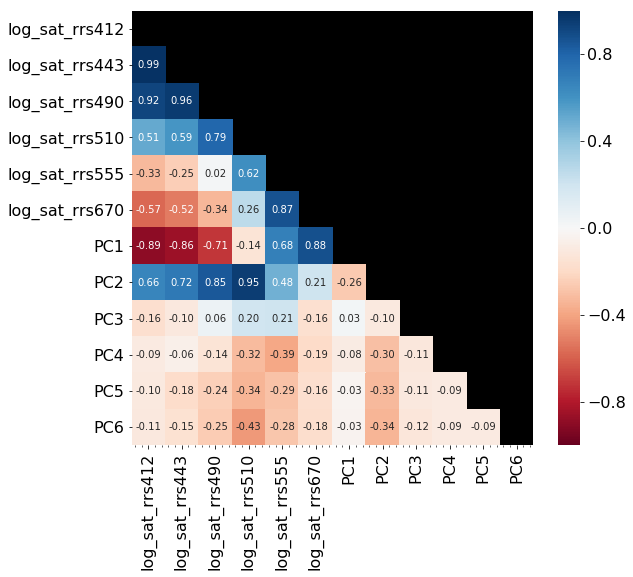

In [188]:
rrs_pc_corr = X_train_rrs.merge(X_train_pca, how='inner',
                                left_index=True, right_index=True).corr()
f = make_heatmap(rrs_pc_corr, figsize=(9, 8))

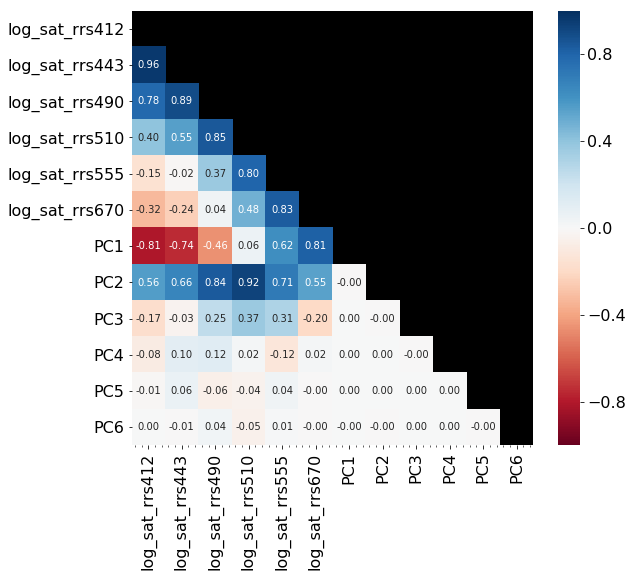

In [159]:
f, ax = pl.subplots(figsize=(9, 8))
ax.set_facecolor('k')
rrs_pc_corr = log_sat_rrs.dropna().merge(df_sat_pca, how='inner', left_index=True,
                                         right_index=True).corr()
sb.heatmap(rrs_pc_corr, vmin=-1, vmax=1, cmap='RdBu',
          mask=np.triu(np.ones(rrs_pc_corr.shape),), annot=True, fmt='.2f')
f.savefig('./resources/heatmap_rrs_pc.png', dpi=300)

In [102]:
df_extr_pc = df_extr[['oisst', 'coastal',
                      'log_chlor_a']].merge(df_sat_pca, how='inner', right_index=True, 
                                        left_index=True)

In [101]:
df_extr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 9 columns):
oisst             292 non-null float64
coastal           292 non-null int64
log_sat_rrs412    276 non-null float64
log_sat_rrs443    285 non-null float64
log_sat_rrs490    291 non-null float64
log_sat_rrs510    292 non-null float64
log_sat_rrs555    292 non-null float64
log_sat_rrs670    281 non-null float64
log_chlor_a       292 non-null float64
dtypes: float64(8), int64(1)
memory usage: 20.6 KB


In [103]:
df_extr_pc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 0 to 291
Data columns (total 9 columns):
oisst          269 non-null float64
coastal        269 non-null int64
log_chlor_a    269 non-null float64
PC1            269 non-null float64
PC2            269 non-null float64
PC3            269 non-null float64
PC4            269 non-null float64
PC5            269 non-null float64
PC6            269 non-null float64
dtypes: float64(8), int64(1)
memory usage: 21.0 KB


### Standardize data:

In [143]:
sc_rrs = StandardScaler()
sc_pc = StandardScaler()

In [144]:
X_huh = sc_rrs.fit_transform(X_train, y_train)

/accounts/ekarakoy/anaconda3/envs/busan_2019/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/accounts/ekarakoy/anaconda3/envs/busan_2019/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


## 4. Models:
Polynomial model a la $OC_4$
Multivariate model with Rrs data
Multivariate model with Rrs data and SST
Multivariate model with PC data 
Multivariate model with PC data and SST